# Import Packages

In [1]:
import pandas as pd
import numpy as np
import nltk
import os
from pprint import pprint
import itertools
#nltk.download()
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Read TextFiles

In [2]:
#read review data
review=[] #create a list of reviews for diff apartments
arr = os.listdir('../data')
strtxt = ".txt"
for txtfile in arr:
    if txtfile.__contains__(strtxt):
        txtfile='../data/'+txtfile
        fileObject = open(txtfile, "r")
        review.append(fileObject.read())
        fileObject.close()

# Clean Text

In [3]:
#splits raw text into individual words
tokenized_text=[]
for text in review: 
    tokenized_text.append(nltk.word_tokenize(text))
#print to check
for i in tokenized_text:
    pprint(i, width=79, compact=True)

['Worst', 'Place', 'I', "'", 've', 'Ever', 'Rented', '.', 'Proceed', 'With',
 'Caution', 'If', 'Apartments.com', 'offered', 'a', 'zero-stars', 'rating',
 ',', 'I', 'would', 'be', 'using', 'it', 'for', 'this', 'tenant-trap', 'of',
 'a', 'property', '.', 'Our', 'disastrous', 'journey', 'began', 'in', 'April',
 'when', 'the', 'leasing', 'agent', 'sold', 'us', 'oceanfront', 'property',
 'in', 'Arizona', '--', 'in', 'other', 'words', ',', 'her', 'leasing', 'spiel',
 'did', 'not', 'come', 'close', 'to', 'matching', 'reality', '.', 'Our',
 'leasing', 'agent', 'stated', 'that', 'the', 'building', 'has', 'a',
 'zero-tolerance', 'policy', 'for', 'noise', 'offenders', 'and', 'drug', 'use',
 '.', 'REALITY', 'CHECK', ':', 'As', 'we', 'were', 'in', 'the', 'process',
 'of', 'moving', 'in', 'and', 'discovered', 'the', 'apartment', 'was',
 'literally', '90', 'degrees', ',', 'we', 'opened', 'the', 'series', 'of',
 'patio', 'doors', 'to', 'get', 'fresh', 'air', '.', 'Well', ',', 'if', 'you',
 'want', 'fr

In [4]:
#filter out punctuation
for i in range(len(tokenized_text)):
    tokenized_text[i] = [w for w in tokenized_text[i] if w.isalpha()]

In [5]:
#delete stopwords
stopwords = nltk.corpus.stopwords.words("english")
for i in range(len(tokenized_text)):
    tokenized_text[i] = [w for w in tokenized_text[i] if w.lower() not in stopwords]

# Find 10 most frequent words/phrase for zip code 90005

In [6]:
zip_text = list(itertools.chain.from_iterable(tokenized_text))
fd = nltk.FreqDist(zip_text) #create frequency distribution
lower_fd = nltk.FreqDist([w.lower() for w in fd])
print(fd.tabulate(10))

 apartment   building management      place        new    helpful   property    leasing   security       live 
        11         10          9          9          8          8          7          6          6          6 
None


In [7]:
#some frequent words above are confusing, so we take a look at frequent phrases to see if there is a meaningful explanation
finder = nltk.collocations.BigramCollocationFinder.from_words(zip_text)
finder.ngram_fd.tabulate(4)

    ('leasing', 'agent')     ('super', 'helpful') ('medical', 'marijuana')         ('fresh', 'air') 
                       4                        4                        3                        2 


From the 10 most frequent words, we find that residents focus on management, year built, security, smoke policy, leasing agent of properties. Also, residents prefer apartments.

# Generate a Word Cloud to visualize our analysis

In [8]:
# Create a cleaned review in a series
  
ser = pd.Series(np.array(zip_text))

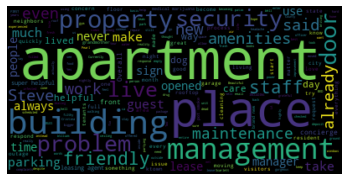

In [9]:
def plot_wordcloud(series,output_filename='wordcloud'):

    wordcloud = WordCloud().generate(' '.join(series.astype(str)))

    wordcloud.to_file(output_filename + '.png')

    plt.imshow(wordcloud, interpolation='bilinear')

    plt.axis("off")

plot_wordcloud(ser,'overall-wordcloud')

# Explore residents' attitudes (positive/negative)

In [10]:
Senti_Analysis = SentimentIntensityAnalyzer()

In [11]:
#create a dataframe of reviews
d = {'reviews': review, 'actual_emotion': ['Negative', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive','Negative',
                                          'Positive','Positive','Positive']}
df = pd.DataFrame(data=d)

In [12]:
def get_sentiment(text:str, analyser,desired_type:str='pos'):
    # Get sentiment from text
    sentiment_score = analyser.polarity_scores(text)
    return sentiment_score[desired_type]

# Get Compound Sentiment scores
def get_sentiment_scores(df,data_column):
    df[f'{data_column} Compound Sentiment Score'] = df[data_column].astype(str).apply(lambda x: get_sentiment(x,Senti_Analysis,'compound'))
    return df

In [13]:
text_sentiment = get_sentiment_scores(df,'reviews')

display(text_sentiment.sample(10))

,reviews,actual_emotion,reviews Compound Sentiment Score
6,DO NOT MOVE HERE! This is why.... 1. This plac...,Negative,0.9284
1,This is my first time to live in an apartment ...,Positive,0.9147
7,Cristina and the staff were very friendly and ...,Positive,0.9757
0,Worst Place I' ve Ever Rented. Proceed With Ca...,Negative,-0.9528
2,"Beautiful, modern new building with a killer r...",Positive,0.9618
9,I' ve lived in this complex for 2 years and it...,Positive,0.9020
4,"Brand new ""luxury"" apartment in k-town with so...",Negative,-0.8983
8,Scarlett was my leasing agent and the tour was...,Positive,0.9956
3,I' ve lived in good old glorious KTown for abo...,Positive,0.9753
5,High end apartments that are extremely spaciou...,Positive,0.9562


In [14]:
#predict Residents' emotions based on score
def label_sentiment(row):
    if row['reviews Compound Sentiment Score']<=0 :
        return 'Negative'
    return 'Positive'
df['pred_emotion'] = df.apply (lambda row: label_sentiment(row), axis=1)

In [15]:
#calculate accuracy of our sentiment analysis
correct = 0
for row_index in range(len(df)):
    if df.loc[row_index]['actual_emotion']==df.loc[row_index]['pred_emotion']:
        correct+=1
accuracy=correct/len(df)
print(accuracy)

0.9


With reviews, we analyze residents' emotions for each apartment and our analysis has high accuracy.